In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn import metrics

# change the max_rows/columns value
pd.set_option('display.max_rows', 30)
pd.set_option('display.max_columns', 30)
pd.set_option('display.width', 1000)

# Data processing

In [2]:
# load the post operation dataset
df_post = pd.read_excel('Activity data non preop.xlsx')
df_post.shape

(36024, 23)

The dataset has 36,024 rows and 23 columns

In [3]:
df_post

,StudyID,StudyVisit,DateReceived,ActivityTypeCode,OtherDescription,ComplexClassification,Performed,Months,AvgTimesMonth,MinutesOccasion,HipPain,ReducedTime,HealthProblem,HealthProblemNote,AgePreOp,Gender,HeightCurrent,WeightCurrent,BMI_Current,SurgeryDate,AgeSurgery,RevisionSurgery,PainEver
0,6001,T2,2010-01-25,aquaf,NaN,1,1,3,1,90.0,0,0,0,NaN,59.0,Male,181.5,100.1,30.39,2007-12-10,59.0,0.0,1
1,6001,T5,2013-02-26,cycle,NaN,1,1,7,12,60.0,0,0,0,NaN,59.0,Male,181.5,100.1,30.39,2007-12-10,59.0,0.0,1
2,6001,T3,2012-01-31,cycle,NaN,1,1,8,16,90.0,0,0,0,NaN,59.0,Male,181.5,100.1,30.39,2007-12-10,59.0,0.0,1
3,6001,T2,2010-01-25,cycle,NaN,1,1,12,15,35.0,0,0,0,NaN,59.0,Male,181.5,100.1,30.39,2007-12-10,59.0,0.0,1
4,6001,T1,2008-12-04,cycle,NaN,1,1,12,30,45.0,0,0,0,NaN,59.0,Male,181.5,100.1,30.39,2007-12-10,59.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36019,9067,Baseline,2012-10-22,walkp,NaN,3,1,12,30,240.0,0,0,0,NaN,79.0,Male,174.0,77.0,25.43,2005-07-25,71.0,NaN,0
36020,9067,Baseline,2012-10-22,weed,NaN,4,1,6,30,240.0,0,0,0,NaN,79.0,Male,174.0,77.0,25.43,2005-07-25,71.0,NaN,0
36021,9067,Baseline,2012-10-22,window,NaN,4,1,2,1,90.0,0,0,0,NaN,79.0,Male,174.0,77.0,25.43,2005-07-25,71.0,NaN,0
36022,9067,Baseline,2012-10-22,zzz other,Farming & Gardening,4,1,2,2,60.0,0,0,0,NaN,79.0,Male,174.0,77.0,25.43,2005-07-25,71.0,NaN,0


In [4]:
# check the missing values
df_post.isna().sum()

StudyID                      0
StudyVisit                   4
DateReceived                 4
ActivityTypeCode             0
OtherDescription         33919
ComplexClassification        0
Performed                    0
Months                       0
AvgTimesMonth                0
MinutesOccasion              0
HipPain                      0
ReducedTime                  0
HealthProblem                0
HealthProblemNote        26756
AgePreOp                    13
Gender                      13
HeightCurrent               13
WeightCurrent               13
BMI_Current                 13
SurgeryDate                 13
AgeSurgery                  13
RevisionSurgery            121
PainEver                     0
dtype: int64

In [5]:
# check the number of 'PainEver'
df_post['PainEver'].sum()

20265

In [6]:
# remove the patients having no pain from all trials (baseline and T1-T5)
keep = df_post.groupby(["StudyID"])["HipPain"].transform(sum) > 0
df_post = df_post.loc[keep]
df_post['PainEver'].sum()

20265

the number of 'PainEver' is equal to the number of the above code. -> Both the code and the data are correct.

In [7]:
# remove the unncessary columns and noisy values ('ActivityTypeCode'='zzz other')
df_post =df_post.drop(["StudyID",'PainEver','ComplexClassification'],axis=1)
df_post = df_post[df_post['HipPain'].notna()]
df_post = df_post[df_post['ActivityTypeCode']!='zzz other']

# add the new columns for later use: activtiyAmount & activtiyFreq
df_post['activtiyAmount'] = df_post['AvgTimesMonth']*df_post['Months']*df_post['MinutesOccasion']/12
df_post['activtiyFreq']=df_post['AvgTimesMonth']*df_post['Months']/12

# delete the unnecessary columns
df_post = df_post.drop(['AvgTimesMonth','Months','MinutesOccasion'],axis=1)
df_post.shape

(19181, 19)

In [8]:
# long data -> wide data: make ActivityTypeCode become variables (columns)
df_post['New']=df_post.groupby(['StudyVisit','HipPain','ReducedTime','HealthProblem','activtiyAmount','activtiyFreq']).cumcount()
df_post=df_post.pivot(values='ActivityTypeCode',index=['StudyVisit','HipPain','ReducedTime','HealthProblem','activtiyAmount','activtiyFreq','New'],columns='ActivityTypeCode').reset_index()
# drop the unnecessary column
df_post = df_post.drop("New",axis=1)
# convert the null values of ActivityTypeCode to binary values
df_post.iloc[:,6:] = df_post.iloc[:,6:].notnull().astype('int')
df_post

C:\Users\vickytc\AppData\Local\Temp\ipykernel_9784\1556362389.py:7: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_post.iloc[:,6:] = df_post.iloc[:,6:].notnull().astype('int')


ActivityTypeCode,StudyVisit,HipPain,ReducedTime,HealthProblem,activtiyAmount,activtiyFreq,aerob,aquaf,backp,badm,baskb,bath,bowl,canrow,carp,...,socc,spade,squash,stairs,swim,table,tennd,tenns,volleyb,walke,walkp,waters,weed,weight,window
0,NaN,0,0,0,60.000000,1.000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,NaN,0,0,0,80.000000,8.000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,NaN,0,0,0,900.000000,30.000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Baseline,0,0,0,0.416667,0.083333,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Baseline,0,0,0,0.416667,0.083333,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19176,T5,1,1,1,3600.000000,30.000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
19177,T5,1,1,1,3600.000000,30.000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19178,T5,1,1,1,5400.000000,30.000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
19179,T5,1,1,1,7200.000000,30.000000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [9]:
# post-op
corr = df_post.corr()
corr.style.background_gradient(cmap='coolwarm')

C:\Users\vickytc\AppData\Local\Temp\ipykernel_9784\2662648219.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df_post.corr()


ActivityTypeCode,HipPain,ReducedTime,HealthProblem,activtiyAmount,activtiyFreq,aerob,aquaf,backp,badm,baskb,bath,bowl,canrow,carp,cycle,dance,fishb,fishs,floor,golfc,golfp,golfr,hike,hock,homeae,homewt,horse,house,jog,liftde,liftla,martial,mow,paint,rake,sail,scuba,shovel,skate,skic,skid,sled,snork,snowbrd,socc,spade,squash,stairs,swim,table,tennd,tenns,volleyb,walke,walkp,waters,weed,weight,window
ActivityTypeCode,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
HipPain,1.000000,0.624684,0.172709,0.055824,0.045989,0.002487,-0.028877,0.013954,-0.001406,0.006872,-0.007287,0.003361,-0.016133,0.006474,-0.035641,0.003843,-0.008454,-0.011412,0.009560,-0.000604,-0.001289,0.005340,0.011614,0.001668,0.017127,-0.037309,0.000481,-0.028013,0.006043,-0.016434,-0.017049,-0.002424,-0.008844,-0.016766,-0.015660,-0.006798,0.003090,-0.009267,-0.002547,-0.014893,-0.005245,-0.011029,-0.021498,0.014759,-0.000811,0.010292,0.013708,0.033350,-0.053792,-0.001623,0.018081,0.008856,-0.005437,0.052871,0.080073,-0.009035,0.027004,-0.007695,-0.035498
ReducedTime,0.624684,1.000000,0.204172,0.038330,0.037555,-0.003787,-0.028408,0.009715,0.008413,-0.003535,-0.004906,0.002937,-0.009715,-0.000832,-0.019529,0.006486,-0.009504,-0.009543,-0.001317,-0.013237,-0.017812,-0.013750,-0.007553,-0.007833,0.010916,-0.028910,-0.005533,-0.014003,-0.002713,-0.007639,-0.012104,-0.006362,-0.015926,-0.013134,-0.008929,-0.017986,-0.003653,-0.015127,-0.017685,-0.014392,-0.002787,-0.004162,-0.015412,0.004856,0.004856,0.007612,-0.004644,0.014674,-0.037128,-0.000735,0.005428,0.008364,-0.003535,0.048996,0.090468,-0.009016,0.033444,-0.018225,-0.024000
HealthProblem,0.172709,0.204172,1.000000,0.055196,0.061322,-0.009621,-0.026708,0.011511,-0.005468,0.004765,-0.014403,0.010480,-0.024128,-0.011832,-0.028125,-0.026232,-0.014412,-0.018407,-0.001117,-0.015310,-0.023407,-0.009819,-0.012471,-0.000683,-0.002932,-0.027287,-0.008438,-0.006148,-0.003013,-0.022160,-0.005229,0.010230,-0.016283,-0.003137,0.008429,-0.011361,-0.001352,-0.002795,-0.019197,-0.005480,-0.004380,-0.014416,-0.016938,0.003971,0.003971,0.008561,0.008098,0.027882,-0.052581,-0.009880,-0.012603,-0.014325,-0.006504,0.038133,0.116668,-0.007743,0.031775,-0.032679,-0.027873
activtiyAmount,0.055824,0.038330,0.055196,1.000000,0.476401,-0.016291,-0.027288,-0.008241,-0.010948,-0.003236,-0.029391,-0.019356,-0.038752,0.028650,-0.044949,-0.067455,-0.026060,-0.025660,-0.056149,0.007663,0.010720,0.005153,-0.036429,-0.007330,-0.008787,-0.032041,0.004868,0.334036,-0.006929,-0.058635,-0.088954,0.002083,-0.068481,-0.030564,-0.090386,-0.015310,-0.011474,-0.082900,-0.026110,-0.020627,-0.019379,-0.012871,-0.022358,-0.006532,-0.002863,-0.069844,-0.007159,-0.098160,-0.053255,-0.012439,0.001650,-0.013647,-0.001250,0.011757,0.389245,-0.011976,-0.063832,-0.020947,-0.074878
activtiyFreq,0.045989,0.037555,0.061322,0.476401,1.000000,-0.033245,-0.053919,-0.022983,-0.023377,-0.007230,-0.035018,-0.052773,-0.084359,-0.075557,-0.062793,-0.140783,-0.076324,-0.057127,-0.104528,-0.025976,-0.070983,-0.091976,-0.091818,-0.021283,0.006918,0.000945,-0.016854,0.431327,-0.007261,-0.024784,-0.042068,-0.008885,-0.148339,-0.109110,-0.186701,-0.048991,-0.025098,-0.169351,-0.055486,-0.046083,-0.058265,-0.026810,-0.046246,-0.014240,-0.009082,-0.144413,-0.016141,0.394293,-0.087707,-0.022504,-0.021201,-0.032431,-0.006886,0.064872,0.385669,-0.024365,-0.150008,-0.026204,-0.156509
aerob,0.002487,-0.003787,-0.009621,-0.016291,-0.033245,1.000000,-0.007925,-0.002206,-0.001910,-0.000697,-0.005959,-0.004249,-0.006901,-0.008112,-0.013050,-0.011307,-0.006041,-0.004446,-0.009509,-0.002611,-0.007079,-0.008445,-0.007734,-0.002467,-0.004474,-0.008837,-0.002747,-0.022863,-0.002417,-0.011364,-0.020569,-0.002260,-0.012406,-0.008851,-0.014873,-0.004102,-0.001910,-0.013982,-0.004501,-0.003490,-0.004555,-0.001973,-0.003661,-0.001102,-0.001102,-0.012989,-0.002034,-0.022560,-0.012003,-0.002206,-0.003198,-0.002961,-0.000697,-0.015290,-0.023112,-0.001778,-0.016978,-0.008127,-0.011587
aquaf,-

In [10]:
# drop the unnecessary column
df_post = df_post.drop(['ReducedTime','StudyVisit','HealthProblem','activtiyAmount','activtiyFreq'], axis=1)

# Logistic regression

In [11]:
# prepare the training and testing datasets
temp = df_post.drop(['HipPain'], axis=1)

X = temp   # independent variables: ActivityTypeCode
y = df_post.loc[:,'HipPain']   # dependent variables

# data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)
#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

# normalization on feature variables (X_train and X_test) except for the target variables
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

# resample the data to make it balanced
sm = SMOTE(random_state = 2)
X_train_res, y_train_res = sm.fit_resample(X_train_std, y_train.ravel())
print('After OverSampling, the shape of train_X: {}'.format(X_train_res.shape))
print('After OverSampling, the shape of train_y: {} \n'.format(y_train_res.shape))
print("After OverSampling, counts of label '1': {}".format(sum(y_train_res == 1)))
print("After OverSampling, counts of label '0': {}".format(sum(y_train_res == 0)))

After OverSampling, the shape of train_X: (20922, 54)
After OverSampling, the shape of train_y: (20922,) 

After OverSampling, counts of label '1': 10461
After OverSampling, counts of label '0': 10461


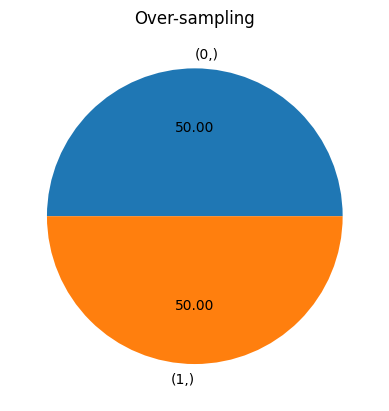

In [12]:
# plot the proportion of '1' and '0'
y_train_res = pd.DataFrame(y_train_res,columns =['a'])
ax = y_train_res.value_counts().plot.pie(autopct='%.2f')
_ = ax.set_title("Over-sampling")

In [13]:
# make instance of model with default parameters 
lr_bal=LogisticRegression(random_state=42)
lr_bal_model=lr_bal.fit(X_train_res,y_train_res)
y_pred_bal=lr_bal_model.predict(X_test_std)
print('Classification report for balanced classes \n',classification_report(y_test,y_pred_bal))

Classification report for balanced classes 
               precision    recall  f1-score   support

           0       0.82      0.58      0.68      4484
           1       0.27      0.56      0.37      1271

    accuracy                           0.57      5755
   macro avg       0.55      0.57      0.52      5755
weighted avg       0.70      0.57      0.61      5755



c:\users\vickytc\appdata\local\programs\python\python39\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


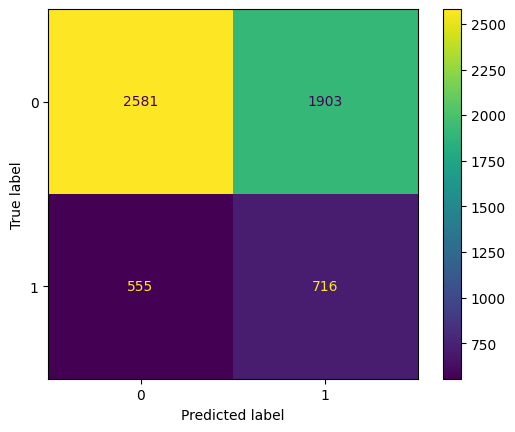

In [14]:
# plot the confusion matrix 
cm = confusion_matrix(y_test,y_pred_bal)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = None)

cm_display.plot()
plt.show()

In [15]:
# The coefficients and the intercept of the logistic regression model
logreg = LogisticRegression(random_state=0).fit(X, y)
print(logreg.coef_, logreg.intercept_) 

[[ 0.15657133 -0.64899004  0.77352161 -0.03126203  0.42742102 -0.12724137
   0.19159574 -0.34356429  0.2036688  -0.43964598  0.13465574 -0.15922717
  -0.37137089  0.23604533  0.03483392  0.04982811  0.17883087  0.30636732
   0.15482041  0.59674485 -0.81398183  0.09236092 -0.13309291  0.37771229
  -0.17316179 -0.06084342 -0.0801153  -0.04005005 -0.25755416 -0.10075529
  -0.19669196  0.24260092 -0.03117537 -0.01368091 -0.70921232 -0.11087928
  -0.75182794 -1.16231696  0.97393132 -0.0212378   0.20528101  0.78802168
   0.30899793 -0.90682944 -0.03381178  0.77612883  0.45905555 -0.31673543
   0.57936703  0.5818609  -0.61394017  0.32469014 -0.08003286 -0.51544559]] [-1.3417457]


Ln(odds) = -1.3417457 + 0.15657133*X1 -0.64899004*X2 + 0.77352161*X3 -0.03126203*X4 + 0.42742102*X5 -0.12724137*X6...

In [16]:
activity =  pd.DataFrame(df_post.columns[1:])
coef = pd.DataFrame(logreg.coef_)
coef =  pd.DataFrame(coef.melt().value) # transpose columns into rows
activity.columns = ['ActivityType']
coef.index = [int(d) for d in range(54)]
coef = pd.concat([activity,coef],axis=1)
coef.sort_values(by='value',ascending=False).style.background_gradient(cmap='summer_r')

,ActivityType,value
38,snowbrd,0.973931
41,squash,0.788022
45,tennd,0.776129
2,backp,0.773522
19,homeae,0.596745
49,walkp,0.581861
48,walke,0.579367
46,tenns,0.459056
4,baskb,0.427421
23,jog,0.377712
